# Install required packages

In [1]:
%cd
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/root
     |████████████████████████████████| 993kB 32.0MB/s 
/root/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.8: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul
[       OK ] ModelBuild

# Download pretrained model

In [2]:
%cd /datalab

import shutil
import glob
import urllib.request
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/datalab


# Edit model config file

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import re

filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100', '/content/drive/My Drive/train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010', '/content/drive/My Drive/test.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/drive/My Drive/labelmap.pbtxt', s)
  f.write(s)

# Train model

In [5]:
!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config \
    --model_dir=/datalab/trained \
    --alsologtostderr \
    --num_train_steps=9000 \
    --num_eval_steps=1500

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0907 16:12:47.643251 140091284129664 deprecation_wrapper.py:119] From /root/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0907 16:12:47.645840 140091284129664 deprecation_wrapper.py:119] From /root/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0907 16:12:47.645980 140091284129664 model_lib.py:617] Forced number of epochs for all eval validations to be 1.

W0907 16:12:47.646089 140091284129664 deprecation_wrapper.py:119] From /root/mode

# Export trained model

In [6]:
%cd /datalab

lst = os.listdir('trained')

# Get model with highest checkpoint number and remove .meta extension
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/datalab




W0907 17:14:13.447731 139670155388800 deprecation_wrapper.py:119] From /root/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0907 17:14:13.452401 139670155388800 deprecation_wrapper.py:119] From /root/models/research/object_detection/exporter.py:381: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0907 17:14:13.452709 139670155388800 deprecation_wrapper.py:119] From /root/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0907 17:14:13.491476 139670155388800 deprecation_wrapper.py:119] From /root/models/research/object_detection/core/preprocessor.py:2412: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0907 17:14:13.536814 139670155388800 deprecation_wrapper.py:119] From /root/models/research/object_detection/meta_archi

# Run inference

In [7]:
%cd ~/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("..")
from object_detection.utils import ops as utils_ops

from utils import label_map_util
from utils import visualization_utils as vis_util

# Path to frozen detection graph. This is the actual model that is used for the object detection
PATH_TO_CKPT = '/datalab/fine_tuned_model/frozen_inference_graph.pb'

# List of strings used to add correct label for each box
PATH_TO_LABELS = os.path.join('/content/drive/My Drive', 'labelmap.pbtxt')

NUM_CLASSES = 12

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

/root/models/research/object_detection


In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# To test the code with other images, add them to the test_images folder
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 5) ]

In [9]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # All outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [10]:
def compute_iou(box, boxes, box_area, boxes_area):
    assert boxes.shape[0] == boxes_area.shape[0]
    ys1 = np.maximum(box[0], boxes[:, 0])
    xs1 = np.maximum(box[1], boxes[:, 1])
    ys2 = np.minimum(box[2], boxes[:, 2])
    xs2 = np.minimum(box[3], boxes[:, 3])
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    unions = box_area + boxes_area - intersections
    ious = intersections / unions
    return ious

In [11]:
def non_max_suppression(boxes, scores, threshold):	
    assert boxes.shape[0] == scores.shape[0]
    ys1 = boxes[:, 0]
    xs1 = boxes[:, 1]
    ys2 = boxes[:, 2]
    xs2 = boxes[:, 3]
    areas = (ys2 - ys1) * (xs2 - xs1)
    scores_indexes = scores.argsort().tolist()
    boxes_keep_index = []
    
    while len(scores_indexes):
        index = scores_indexes.pop()
        boxes_keep_index.append(index)
        if not len(scores_indexes):
            break
        ious = compute_iou(boxes[index], boxes[scores_indexes], areas[index],
                           areas[scores_indexes])
        filtered_indexes = set((ious > threshold).nonzero()[0])
        scores_indexes = [
            v for (i, v) in enumerate(scores_indexes)
            if i not in filtered_indexes
        ]
        
    return np.array(boxes_keep_index)

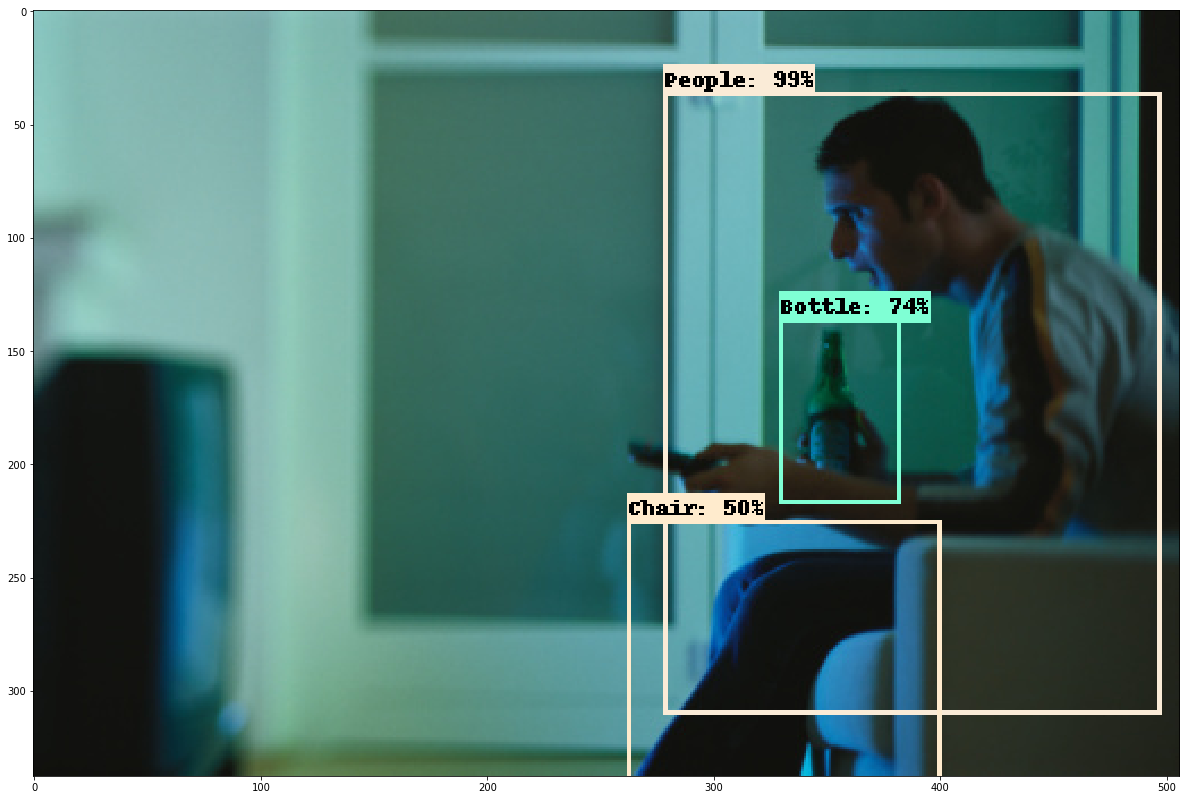

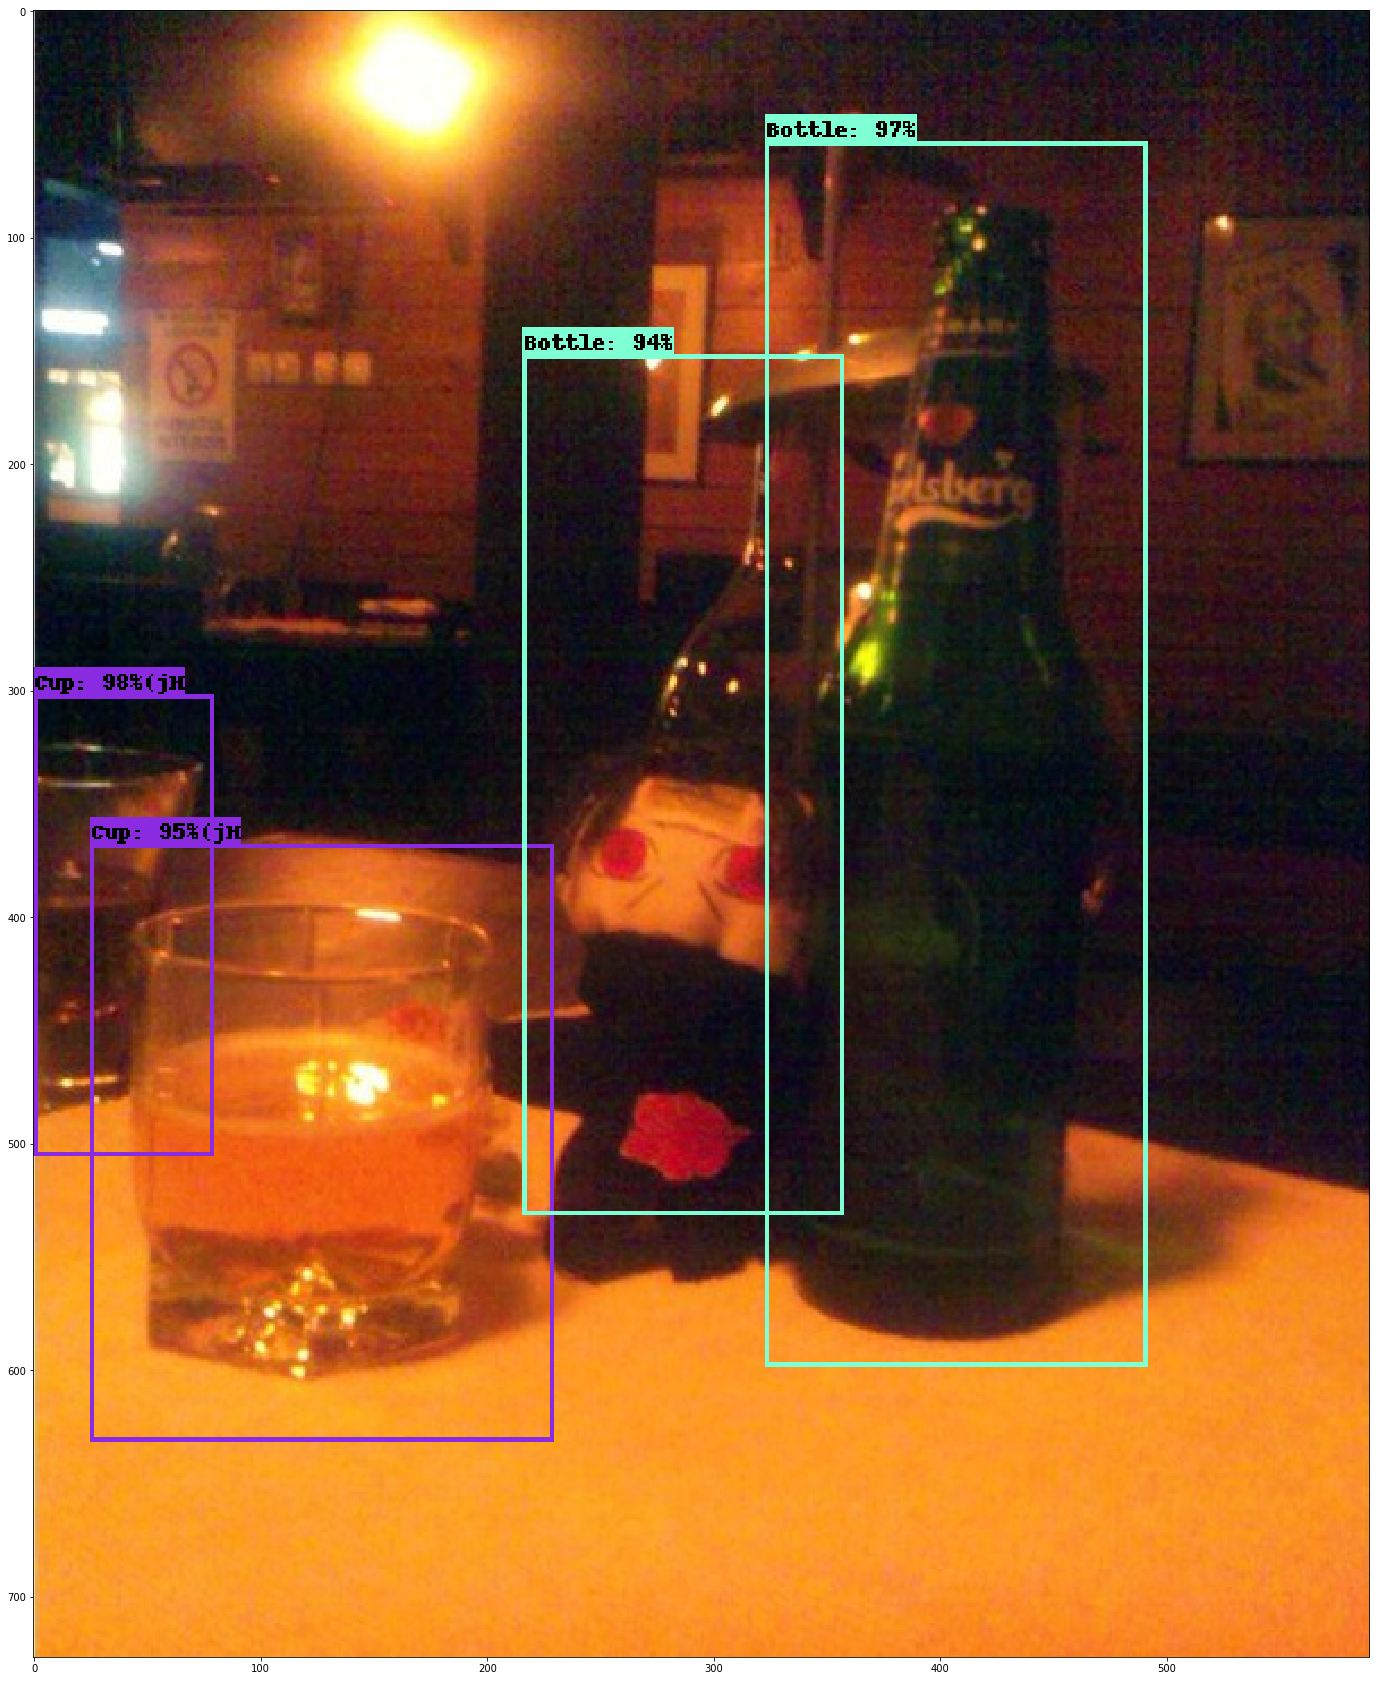

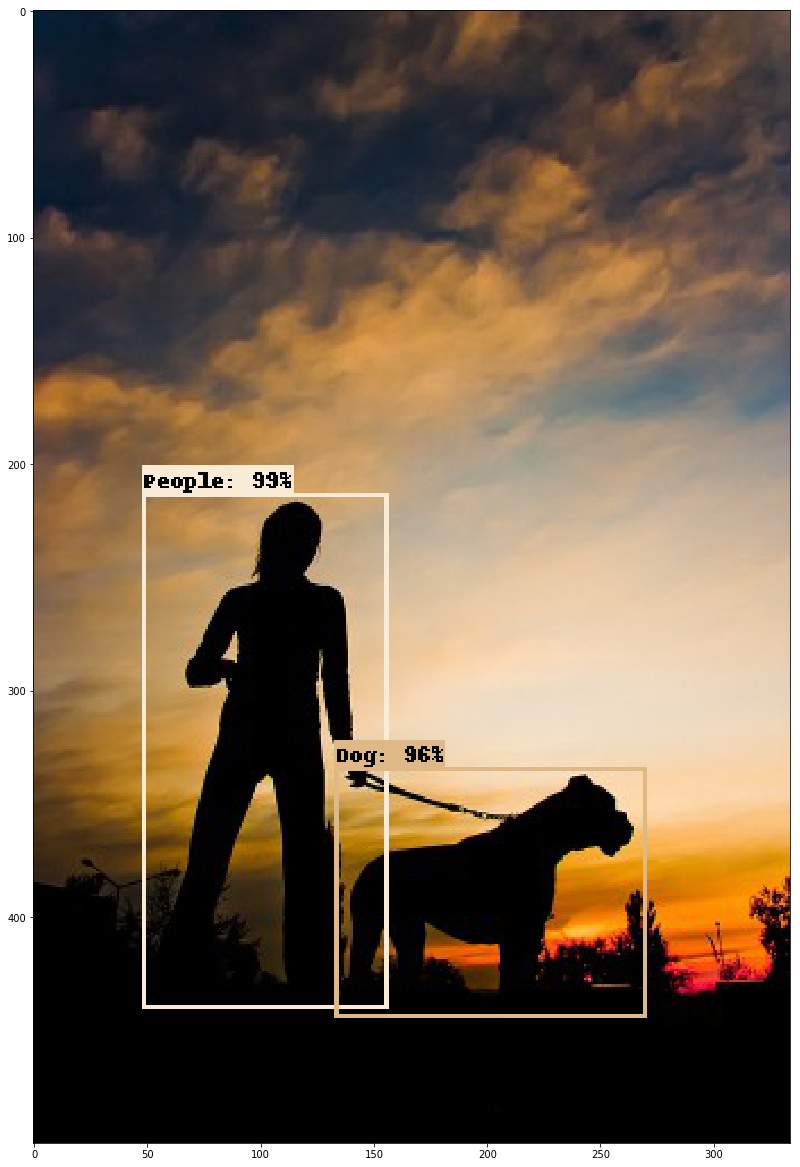

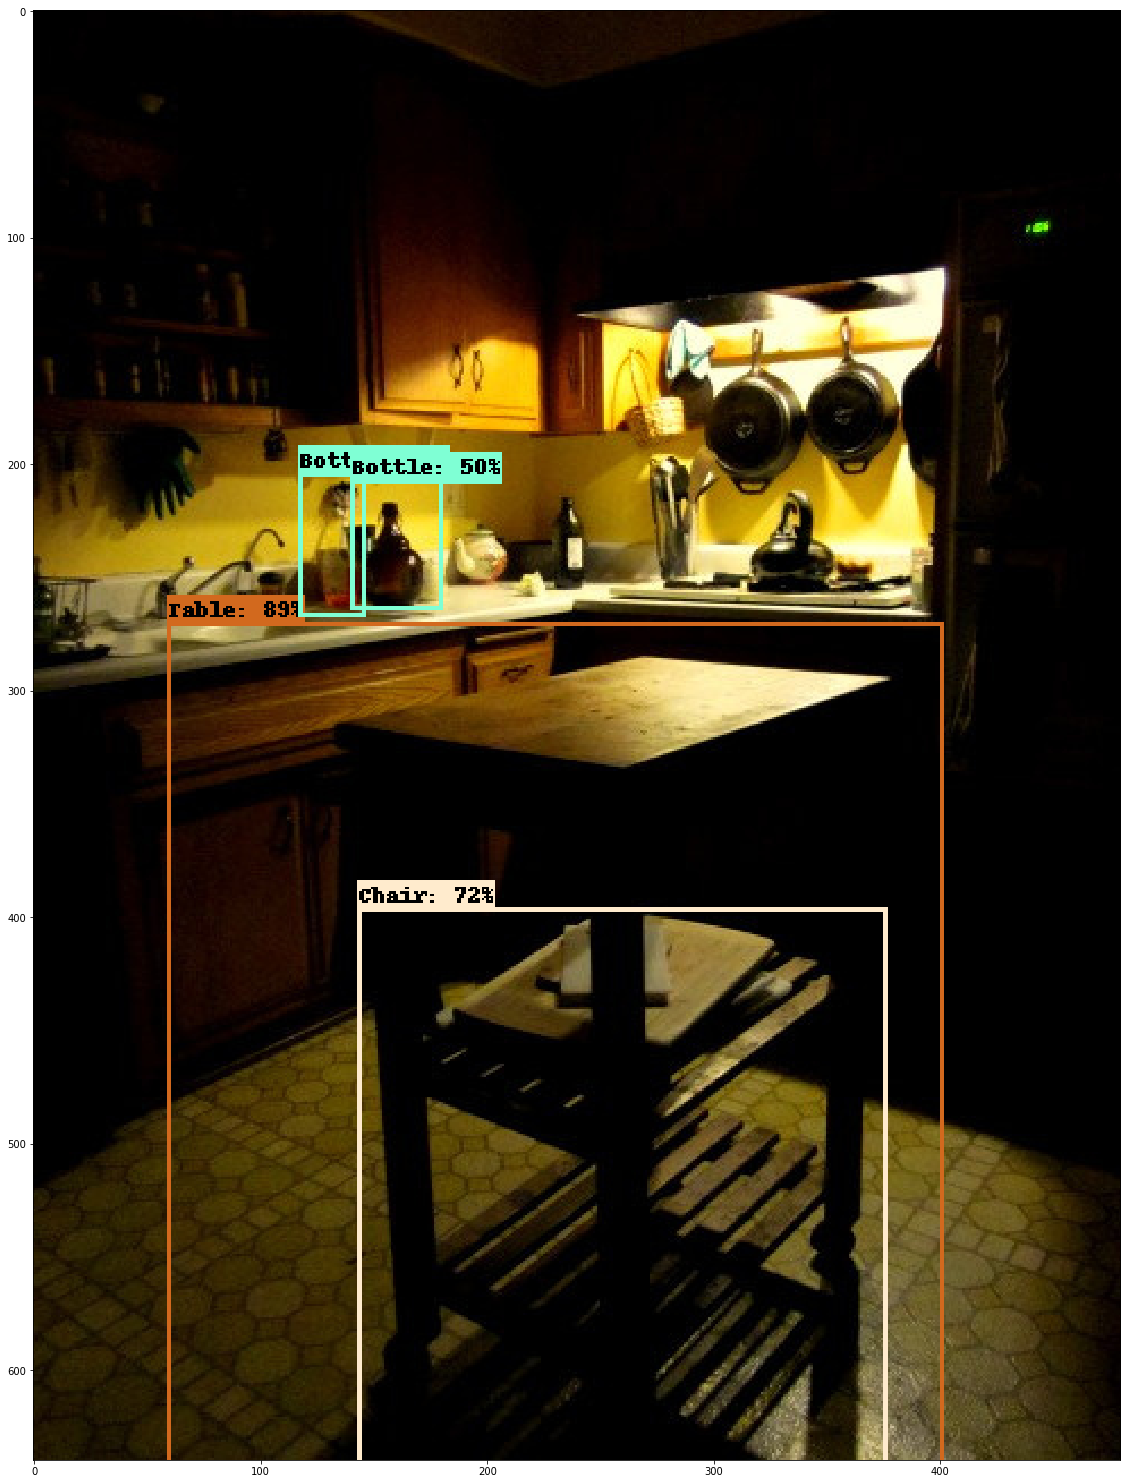

In [12]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  width, height = image.size
  
  # Array-based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it
  image_np = load_image_into_numpy_array(image)
  
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # Actual detection
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # Non-max suppression to prevent duplicate detections
  indices = non_max_suppression(
      output_dict['detection_boxes'],
      output_dict['detection_scores'],
      0.5
  )
  
  # Visualization of the results of a detection
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'][indices],
      output_dict['detection_classes'][indices],
      output_dict['detection_scores'][indices],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2
  )

  # This is needed to display the images
  %matplotlib inline
  
  # Set figure size (in inches) based on width and height of each image
  IMAGE_SIZE = (width / 24, height / 24)
  plt.figure(figsize=IMAGE_SIZE)
    
  plt.imshow(image_np)
  plt.show()